In [1]:
import tensorflow as tf
from datetime import datetime
import model_scale3 as m3
import h5py
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.misc import imsave 
import time

d:\python\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
def read_hdf5(file_name):
    with h5py.File(file_name, 'r') as f:
        images1 = np.asarray(f['images1'])
        images2 = np.asarray(f['images2'])
        images3 = np.asarray(f['images3'])
        images4 = np.asarray(f['images4'])
        depths = np.asarray(f['depths'])
    return images1,images2,images3,images4,depths
images1,images2,images3,images4,depths = read_hdf5('test_multidim_data.h5')
print(images2.shape)
print(images4.shape)
print(depths.shape)

def test_scale3(infrareds2, infrareds4):
    with tf.Graph().as_default():
        x0 = tf.placeholder(tf.float32, [4, 40, 144, 1])
        images = tf.placeholder(tf.float32, [4, 160, 576, 1])
        label = tf.placeholder(tf.float32, [4, 40, 144, 1])
        logits= m3.inference_1(images)
        saver = tf.train.Saver()
        with tf.Session() as sess:
            saver.restore(sess, 'scale3-80000_new/model.ckpt-80000')
            labels = sess.run([logits],feed_dict={x0:infrareds2, images:infrareds4})
    return labels 

(1012, 40, 144)
(1012, 160, 576)
(1012, 40, 144)


In [8]:
def Evaluation(images2,images4,depths):
    rel = 0
    log = 0
    rms = 0
    threshold = []
    inter = 20
    for i in range (inter):
        infraredtest4 = images4[(i*4) : ((i+1)*4)]
        infraredtest2 = images2[(i*4) : ((i+1)*4)]
        depthtest = depths[(i*4) : ((i+1)*4)]
        test_infrared2 = np.reshape(infraredtest2, [4, 40, 144, 1])
        test_infrared4 = np.reshape(infraredtest4, [4, 160, 576, 1])
        
        labels = test_scale3(test_infrared2, test_infrared4)   # list   1*4*40*144*32
        
        labels = np.array(labels)
        labels=np.reshape(labels,[4,40,144,32])
        pred = np.argmax(labels, 3)      # array[4,40,144]  
        d = np.reshape(depthtest, (-1))+1    # 拉直
        d_p = np.reshape(pred, (-1))+1       # 拉直
        
        rel+= np.sum(np.abs(d - d_p) / d )
        log+= np.sum(np.abs(np.log10(d) - np.log10(d_p)))
        rms+= np.sum(np.square((d - d_p)))   # np.square()平方
        threshold= np.append(threshold, np.maximum(d/d_p, d_p/d))
    a = threshold < 1.25
    b = threshold < 1.25*1.25
    c = threshold < 1.25*1.25*1.25
    rel = rel/ (4*40*144*inter)
    log = log/ (4*40*144*inter)
    rms = np.sqrt(rms/(4*144*40*inter))
    threshold1 = np.sum(a == True)/(4*144*40*inter)
    threshold2 = np.sum(b == True)/(4*144*40*inter)
    threshold3 = np.sum(c == True)/(4*144*40*inter)
    
    return rel, log, rms, threshold1, threshold2, threshold3

rel, log, rms, threshold1, threshold2, threshold3 = Evaluation(images2,images4,depths)

format_str = "%s    rel =  %0.3f   log10 = %0.3f   rms = %0.3f   threshold1 = %0.3f   threshold2 = %0.3f  threshold3 = %0.3f"
print('评价指标：',format_str%(datetime.now(), rel, log, rms, threshold1, threshold2, threshold3)) 

model has been done...
INFO:tensorflow:Restoring parameters from scale3-80000_new/model.ckpt-80000
model has been done...
INFO:tensorflow:Restoring parameters from scale3-80000_new/model.ckpt-80000
model has been done...
INFO:tensorflow:Restoring parameters from scale3-80000_new/model.ckpt-80000
model has been done...
INFO:tensorflow:Restoring parameters from scale3-80000_new/model.ckpt-80000
model has been done...
INFO:tensorflow:Restoring parameters from scale3-80000_new/model.ckpt-80000
model has been done...
INFO:tensorflow:Restoring parameters from scale3-80000_new/model.ckpt-80000
model has been done...
INFO:tensorflow:Restoring parameters from scale3-80000_new/model.ckpt-80000
model has been done...
INFO:tensorflow:Restoring parameters from scale3-80000_new/model.ckpt-80000
model has been done...
INFO:tensorflow:Restoring parameters from scale3-80000_new/model.ckpt-80000
model has been done...
INFO:tensorflow:Restoring parameters from scale3-80000_new/model.ckpt-80000
model has 

model has been done...
INFO:tensorflow:Restoring parameters from scale3-80000_new/model.ckpt-80000


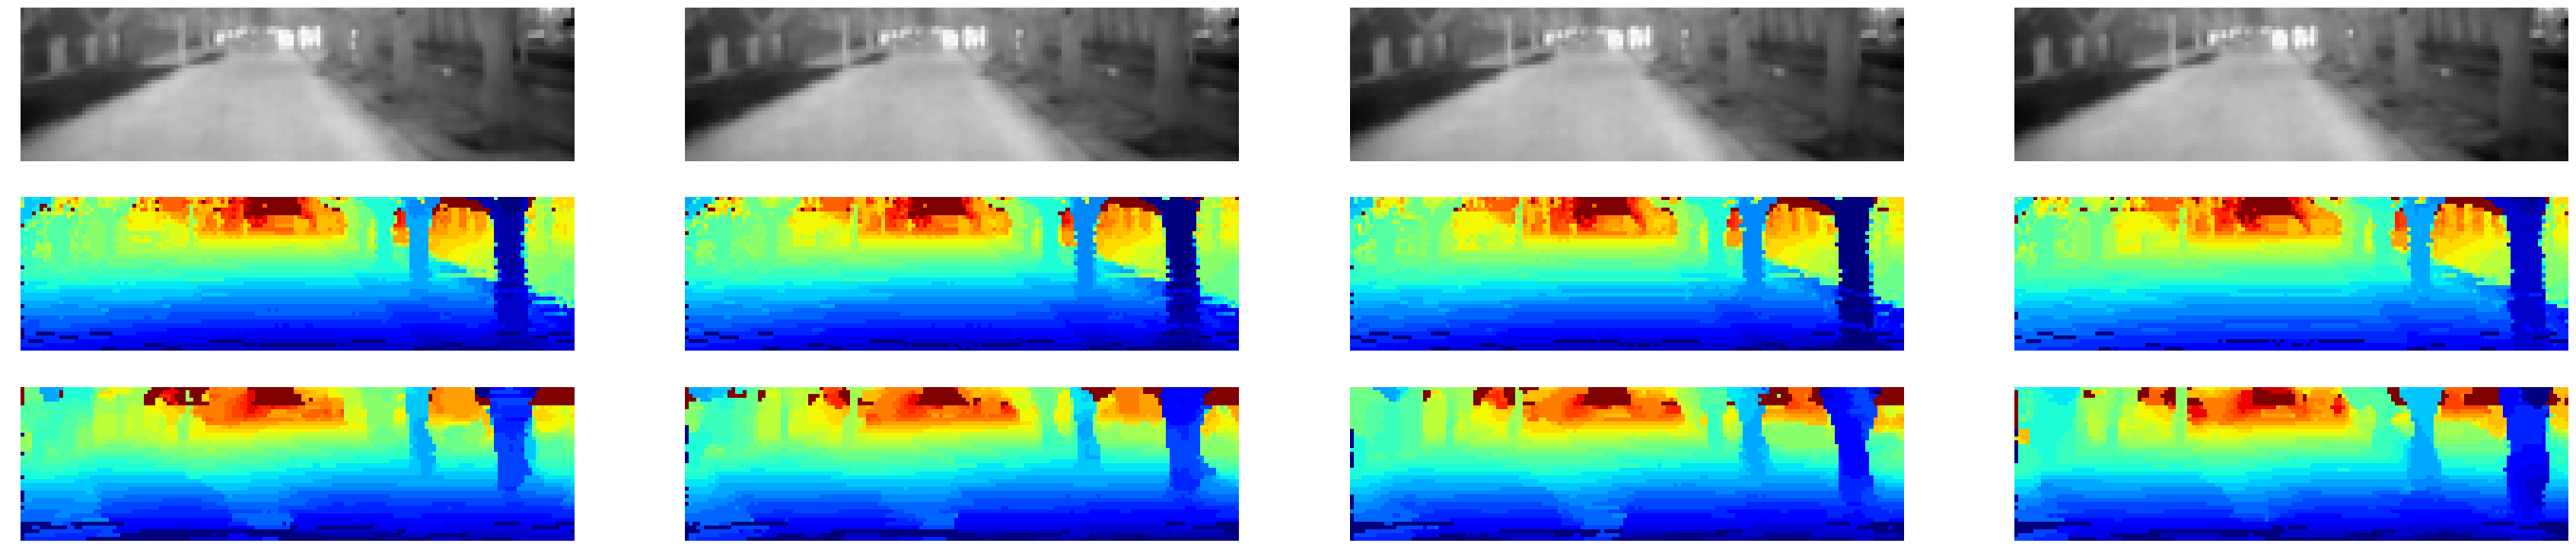

In [9]:
format_str = "%s    accuracy =  %0.3f"
def pred(i,j,images2,images4,depths):
    infraredtest2 = images2[i:j]
    infraredtest4 = images4[i:j]
    depthtest = depths[i:j]
    test_infrared2 = np.reshape(infraredtest2, [4, 40, 144, 1])
    test_infrared4 = np.reshape(infraredtest4, [4, 160, 576, 1])
    y = test_scale3(test_infrared2, test_infrared4)
    y=np.array(y)
    y=np.reshape(y, [4, 40, 144, 32])
    pred1 = np.reshape(np.argmax(y, 3),[4,40,144])
    return pred1,depthtest,infraredtest2,infraredtest4

pred1,depthtest,infraredtest2,infraredtest4 = pred(800,804,images2,images4,depths)
plt.figure(figsize=(60,13))
plt.subplot(341)
plt.imshow(infraredtest2[0], cmap = 'gray')
plt.axis('off')
plt.subplot(342)
plt.imshow(infraredtest2[1], cmap = 'gray')
plt.axis('off')
plt.subplot(343)
plt.imshow(infraredtest2[2], cmap = 'gray')
plt.axis('off')
plt.subplot(344)
plt.imshow(infraredtest2[3], cmap = 'gray')
plt.axis('off')
plt.subplot(345)
plt.imshow(depthtest[0], cmap = 'jet')  
plt.axis('off')
plt.subplot(346)
plt.imshow(depthtest[1], cmap = 'jet')
plt.axis('off')
plt.subplot(347)
plt.imshow(depthtest[2], cmap = 'jet')
plt.axis('off')
plt.subplot(348)
plt.imshow(depthtest[3], cmap = 'jet')
plt.axis('off')
plt.subplot(349)
plt.imshow(pred1[0], cmap = 'jet')
plt.axis('off')
plt.subplot(3,4,10)
plt.imshow(pred1[1], cmap = 'jet')
plt.axis('off')
plt.subplot(3,4,11)
plt.imshow(pred1[2], cmap = 'jet')
plt.axis('off')
plt.subplot(3,4,12)
plt.imshow(pred1[3], cmap = 'jet')
plt.axis('off')
# plt.savefig('eigen2_groundtruth222-226.png')
plt.show()
# imsave('eigen2_223-groundtruth.png', depthtest[1])